# Nutria
In this Notebook we'll consider the population growth of the Nutria species. The data has been taken from .. . We'll begin importing the data and visualizing it.

<AxesSubplot:title={'center':'Nutria population'}>

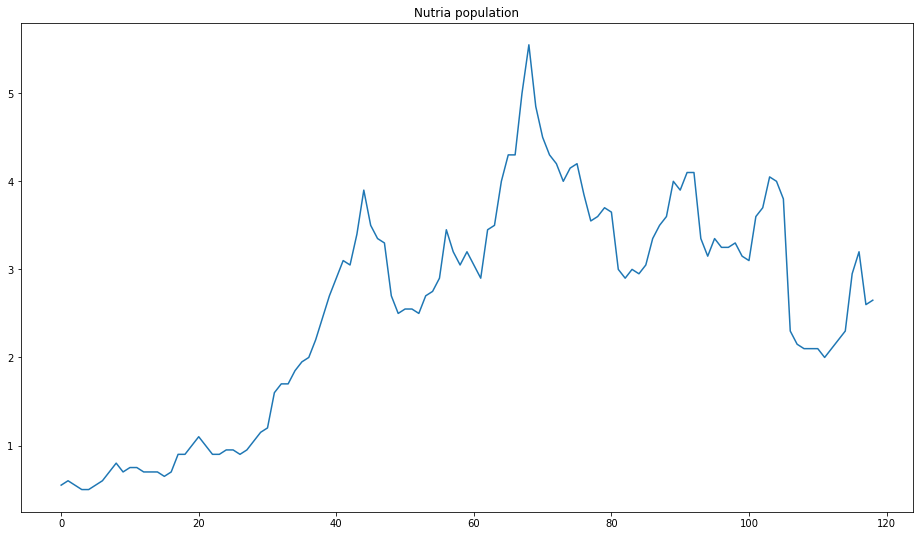

In [1]:
import pandas as pd

data = pd.read_csv("nutria.txt", sep="\t").iloc[:, 0].rename("nutria")

data.plot(figsize=(16, 9), title="Nutria population")

Next, we'll specify the model to use for inference. We'll use the flexible Allee model, found in .. . 

In [2]:
from stochproc.timeseries import StateSpaceModel, AffineProcess, GeneralObservable
import torch
import pyro
from pyro.distributions import InverseGamma, Normal, FoldedDistribution, LogNormal, Uniform
from stochproc.distributions import DistributionModule


def f(x, a, b, c, d):
    exped = x.values.exp()
    return x.values + a + b * exped + c * exped ** 2, d.sqrt()


def obs_builder(x, s):
    return Normal(loc=x.values, scale=s)


def nutria_model(x):
    a = pyro.sample("a", Normal(loc=0.0, scale=0.5))
    b = pyro.sample("b", Normal(loc=0.0, scale=0.25))
    c = pyro.sample("c", Normal(loc=0.0, scale=0.15))
    
    alpha = x.shape[0] / 2.0
    beta = 2 * (alpha - 1.0) / 10.0                
    d = pyro.sample("d", InverseGamma(concentration=alpha, rate=beta))
    
    initial_values = pyro.sample("initial_values", LogNormal(loc=-1.0, scale=1.0))
    initial_dist = DistributionModule(Normal, loc=initial_values, scale=0.25)
    
    inc_dist = DistributionModule(Normal, loc=0.0, scale=1.0)
    
    hidden = AffineProcess(f, (a, b, c, d), initial_dist, inc_dist)
        
    sigma = 0.15 # This would optimally be estimated...
    obs = GeneralObservable((sigma,), obs_builder, torch.Size([]))
    
    model = StateSpaceModel(hidden, obs)
    model.do_sample_pyro(pyro, x, mode="approximate")
    

Next, we'll use SVI to perform inference

In [3]:
from tqdm import tqdm

y = torch.from_numpy(data.values).float()

guide = pyro.infer.autoguide.AutoDiagonalNormal(nutria_model)
optim = pyro.optim.Adam({"lr": 1e-2})
svi = pyro.infer.SVI(nutria_model, guide, optim, loss=pyro.infer.Trace_ELBO())

niter = 50_000
pyro.clear_param_store()

running_average = 0.0
smoothing = 0.99

bar = tqdm(range(niter))
for n in bar:
    loss = svi.step(y)
    
    running_average = smoothing * running_average + (1 - smoothing) * loss
    bar.set_description(f"Loss: {running_average:,.2f}")

Loss: 630.52: 100%|██████████████████████████████████████████████████████████████| 50000/50000 [09:23<00:00, 88.70it/s]


Let's plot the posterior distribution of the parameters.

array([<AxesSubplot:title={'center':'a\n0'}>,
       <AxesSubplot:title={'center':'b\n0'}>,
       <AxesSubplot:title={'center':'c\n0'}>,
       <AxesSubplot:title={'center':'d\n0'}>], dtype=object)

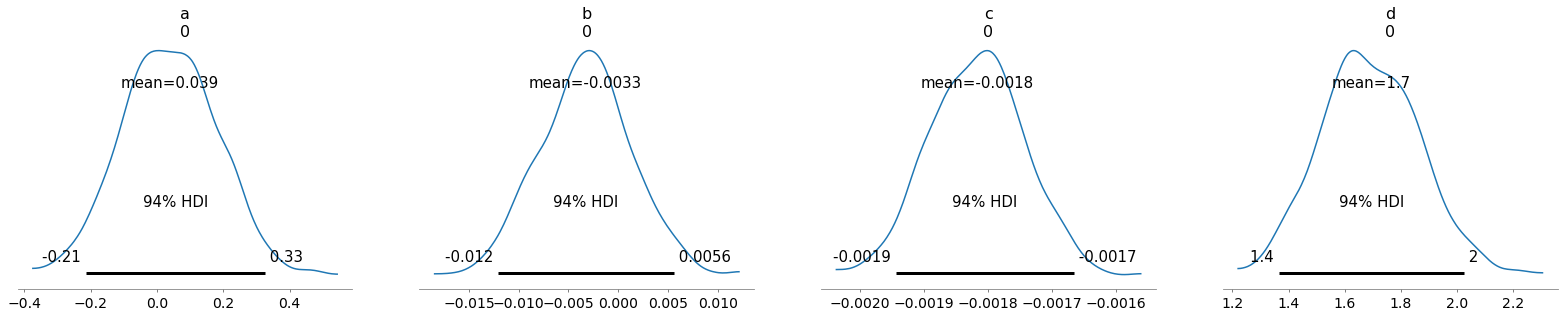

In [4]:
from pyro.infer import Predictive
import arviz
import pandas as pd

num_samples = 1_000

posterior_predictive = Predictive(
    nutria_model,
    guide=guide,
    num_samples=num_samples
)

posterior_draws = {k: v.unsqueeze(0) for k, v in posterior_predictive(y).items()}

posteriors = arviz.from_dict(posterior_draws)
arviz.plot_posterior(posteriors, var_names=["a", "b", "c", "d"])

And finally visualize the inferred distributions of the latent state.

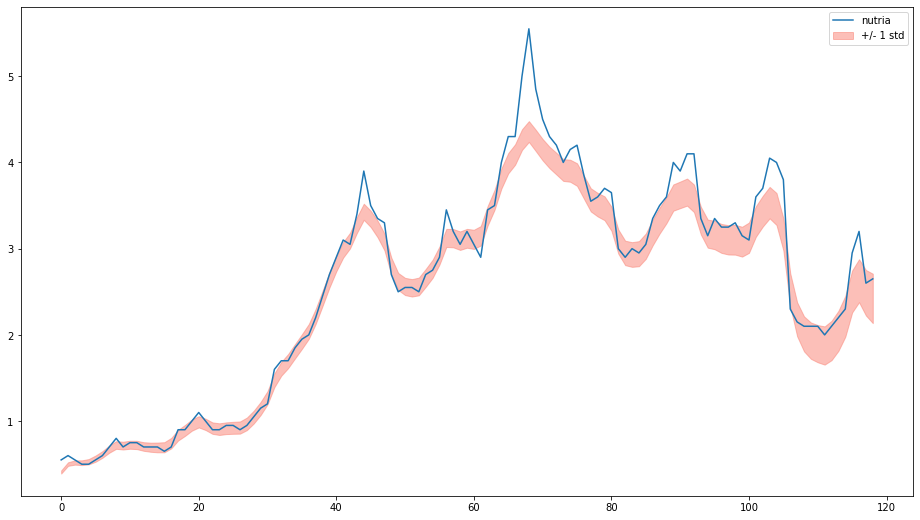

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

data.plot(ax=ax)

squeezed = posterior_draws["auxiliary"].squeeze(0).squeeze(-2)

mean = squeezed.mean(0)
std = squeezed.std(0)

high = mean + std
low = mean - std

ax.fill_between(data.index, low[1:], high[1:], alpha=0.5, color="salmon", label="+/- 1 std")

ax.legend()